 
# Texas Produced Water Dataset Analysis before the Permian Oil Shale Revolution (1920 - 2010)

======================================================================================================================


The following code was implemented to clean and analyze the datasets obtained from the United States Geological Survey (USGS) National Produced Waters Database v2.3: https://energy.usgs.gov/EnvironmentalAspects/EnvironmentalAspectsofEnergyProductionandUse/ProducedWaters.aspx#3822349-data 

Texas is the epicenter of the Permian oil shale revolution, and hydraulic fracture of the rock involves tons of water, mixed with binding and cross-linking agents, emulsifiers and other chemicals. The idea is to pump water into the shale formation with such pressure and volume, that the rock cracks. The well is shut tight for a few days, and then reopened when it starts to produce oil and gas. As this crude is produced, the water injected previously also flows back. Handling of this flowback water is a major concern for oil and gas producers, as they cannot release it into the environment untreated. One solution is to reinject this flowback water into older non-producing wells and formations, after removal of the chemicals. 

The reinjection process must pass through several environmental constraints, one of them being that the water to be injected must match the characteristics of the water originally produced from the target formations. As a result, the oil producer companies must run surveys of well produced water characteristics. The motivation behind the present study was to study the quality of produced water in several areas of Texas (in terms of total dissolved solids [TDS]), and whether a model can be developed to help predict the water quality given other known parameters.  

Several characteristics of the waters from these wells can be studied, such as total dissolved solids (TDS), mineral content, basin characteristics, type of wells, location where they are present, and time-series data on water properties. The current analysis attempts to answer several questions and hypotheses from this dataset, and to produce descriptive statistics from it. 

<div class="alert alert-warning" role="alert">

## Data Cleaning and Wrangling
</div>

First the major libraries were imported, and the file read into a Pandas dataframe, df.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

plt.style.use('seaborn-pastel')
sns.set_palette('Set2')

from scipy.stats import linregress

In [2]:
file = 'Texas Wells.xlsx'
df = pd.read_excel(file)

Next, we examine the data contained within this huge dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19388 entries, 0 to 19387
Columns: 190 entries, IDUSGS to cull_chargeb
dtypes: float64(104), int64(2), object(84)
memory usage: 28.1+ MB


Since there are 190 columns and 19388 entries, some data cleaning needs to be implemented. There are multiple columns in the dataset that are empty, and so the first step is to remove them, and add them to a new dataframe, df_drop. 

In [4]:
# deleting column that are null values
df_drop = df.dropna(axis= 1, how='all')

print(df.info())
print(df_drop.info())

# number of attributes dropped to 129 from 190

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19388 entries, 0 to 19387
Columns: 190 entries, IDUSGS to cull_chargeb
dtypes: float64(104), int64(2), object(84)
memory usage: 28.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19388 entries, 0 to 19387
Columns: 129 entries, IDUSGS to cull_chargeb
dtypes: float64(43), int64(2), object(84)
memory usage: 19.1+ MB
None


Data is then cleaned by focusing only on the main parameters of interest (from domain knowledge), i.e. 'LATITUDE', 'LONGITUDE', 'API', 'USREGION', 'BASIN', 'COUNTY', 'WELLNAME', 'WELLTYPE', 'DATECOMP', 'DATESAMPLE', 'FORMATION', 'PERIOD', 'DEPTHUPPER', 'DEPTHLOWER', 'DEPTHWELL', 'SPGRAV', 'PH', 'TDSUSGS', 'HCO3', 'Ca', 'Cl', 'KNa', 'Mg', 'Na', 'SO4', 'H2S', 'cull_chargeb'. 

In [5]:
# cleaning the data to reduce the parameters to 26
df_drop = df_drop[['LATITUDE','LONGITUDE','API','BASIN','COUNTY','WELLNAME','WELLTYPE','DATECOMP','DATESAMPLE','FORMATION','PERIOD','DEPTHUPPER','DEPTHLOWER','DEPTHWELL','SPGRAV','PH','TDSUSGS','HCO3','Ca','Cl','KNa','Mg','Na','SO4','H2S','cull_chargeb']]      
df_drop.head()

,LATITUDE,LONGITUDE,API,BASIN,COUNTY,WELLNAME,WELLTYPE,DATECOMP,DATESAMPLE,FORMATION,...,TDSUSGS,HCO3,Ca,Cl,KNa,Mg,Na,SO4,H2S,cull_chargeb
0,31.90,-101.44,NaN,Permian,Glasscock,NaN,Conventional Hydrocarbon,NaN,2014-01-23,Fusselman,...,69000.0,NaN,2190,39800,NaN,403,22200,1580,NaN,NaN
1,31.91,-101.44,NaN,Permian,Glasscock,NaN,Tight Oil,NaN,2014-01-23,Cline Shale,...,79900.0,NaN,2450,46300,NaN,329,25200,351,NaN,NaN
2,31.86,-101.47,NaN,Permian,Glasscock,NaN,Conventional Hydrocarbon,NaN,2014-01-23,Wolfwood (Wolfcamp/Woodford),...,127000.0,NaN,8010,75100,NaN,1130,36800,304,NaN,NaN
3,31.99,-101.49,NaN,Permian,Glasscock,NaN,Tight Oil,NaN,2014-01-23,Cline Shale,...,37700.0,NaN,572,13400,NaN,78.2,12900,<300,NaN,X
4,31.98,-101.49,NaN,Permian,Glasscock,NaN,Conventional Hydrocarbon,NaN,2014-01-23,Fusselman,...,72400.0,NaN,2470,40900,NaN,474,22700,1530,NaN,NaN


Thus the final number of parameters fell down to 26. Next we focus on converting dates to datetime format, and other objects types into float64. 

In [6]:
# converting dates to datetime
df_drop.DATECOMP = pd.to_datetime(df_drop.DATECOMP, errors='coerce')
df_drop.DATESAMPLE = pd.to_datetime(df_drop.DATESAMPLE, errors='coerce')

# converting all other numeric types into floats
df_drop.SPGRAV = pd.to_numeric(df_drop.SPGRAV, errors='coerce')
df_drop.PH = pd.to_numeric(df_drop.PH, errors='coerce')
df_drop.HCO3 = pd.to_numeric(df_drop.HCO3, errors='coerce')
df_drop.Ca = pd.to_numeric(df_drop.Ca, errors='coerce')
df_drop.Cl = pd.to_numeric(df_drop.Cl, errors='coerce')
df_drop.KNa = pd.to_numeric(df_drop.KNa, errors='coerce')
df_drop.Mg = pd.to_numeric(df_drop.Mg, errors='coerce')
df_drop.Na = pd.to_numeric(df_drop.Na, errors='coerce')
df_drop.SO4 = pd.to_numeric(df_drop.SO4, errors='coerce')
df_drop.H2S = pd.to_numeric(df_drop.H2S, errors='coerce')


print(df_drop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19388 entries, 0 to 19387
Data columns (total 26 columns):
LATITUDE        16631 non-null float64
LONGITUDE       16635 non-null float64
API             8208 non-null float64
BASIN           19388 non-null object
COUNTY          19317 non-null object
WELLNAME        19087 non-null object
WELLTYPE        19388 non-null object
DATECOMP        1648 non-null datetime64[ns]
DATESAMPLE      16734 non-null datetime64[ns]
FORMATION       19388 non-null object
PERIOD          19388 non-null object
DEPTHUPPER      13614 non-null float64
DEPTHLOWER      11050 non-null float64
DEPTHWELL       9276 non-null float64
SPGRAV          16936 non-null float64
PH              16404 non-null float64
TDSUSGS         19373 non-null float64
HCO3            18157 non-null float64
Ca              19305 non-null float64
Cl              19351 non-null float64
KNa             2342 non-null float64
Mg              19154 non-null float64
Na              17020 non-nul

As can be seen here, there is a lot of data that is missing or incomplete, and needs to be dealt with. Let us tackle them one by one.

<div class="alert alert-warning" role="alert">

### Missing Latitudes and Longitudes
</div>

In [7]:
# Analyzing the total number of missing lat and long data
print('Null values for the Latitude: ' + str(df_drop.LATITUDE.isnull().sum()))
print('Null values for the Longitude: ' + str(df_drop.LONGITUDE.isnull().sum()))

Null values for the Latitude: 2757
Null values for the Longitude: 2753


We decide to drop the missing latitudes and longitudes, as there is no easy way to impute their values

In [8]:
# Dropped the empty lat/lon values
df_drop = df_drop[df_drop.LATITUDE.notnull()]
df_drop = df_drop[df_drop.LONGITUDE.notnull()]
df_drop.head()

,LATITUDE,LONGITUDE,API,BASIN,COUNTY,WELLNAME,WELLTYPE,DATECOMP,DATESAMPLE,FORMATION,...,TDSUSGS,HCO3,Ca,Cl,KNa,Mg,Na,SO4,H2S,cull_chargeb
0,31.90,-101.44,NaN,Permian,Glasscock,NaN,Conventional Hydrocarbon,NaT,2014-01-23,Fusselman,...,69000.0,NaN,2190.0,39800.0,NaN,403.0,22200.0,1580.0,NaN,NaN
1,31.91,-101.44,NaN,Permian,Glasscock,NaN,Tight Oil,NaT,2014-01-23,Cline Shale,...,79900.0,NaN,2450.0,46300.0,NaN,329.0,25200.0,351.0,NaN,NaN
2,31.86,-101.47,NaN,Permian,Glasscock,NaN,Conventional Hydrocarbon,NaT,2014-01-23,Wolfwood (Wolfcamp/Woodford),...,127000.0,NaN,8010.0,75100.0,NaN,1130.0,36800.0,304.0,NaN,NaN
3,31.99,-101.49,NaN,Permian,Glasscock,NaN,Tight Oil,NaT,2014-01-23,Cline Shale,...,37700.0,NaN,572.0,13400.0,NaN,78.2,12900.0,NaN,NaN,X
4,31.98,-101.49,NaN,Permian,Glasscock,NaN,Conventional Hydrocarbon,NaT,2014-01-23,Fusselman,...,72400.0,NaN,2470.0,40900.0,NaN,474.0,22700.0,1530.0,NaN,NaN


<div class="alert alert-warning" role="alert">

### Missing Depths
</div>

The following code deals with replacing missing depths in the dataset with known values of latitudes and longitudes. The idea is implemented stepwise as follows: 

<div class="alert alert-info" role="alert">
1. Create a dataframe with all the missing values for DEPTHUPPER: <i> col_missing </i> <br>
2. Initialize an empty list <i> filled_depths </i> which will contain mini-dataframes of the same well <br>
3. Going sequentially in this <i> col_missing </i> dataframe, search the main dataframe <i> df_drop </i> for latitudes and longitudes which correspond to the missing latitudes and longitudes of <i> col_missing </i>, and filter these rows into a new smaller <i> slices </i> dataframe. **We assume that the latitude and longitude values would be able to identify the same wells properly from the dataset**. <br>
4. If any of the DEPTHUPPER columns in <i> slices </i> is NaN, its value will be replaced by the mean of the other non-empty DEPTHUPPER values, and the resulting <i> slices </i> will be appended to <i> filled_depths </i> list. Else, the <i> slices </i> will be added as it is onto the <i> filled_depths </i> list. <br>
5. Thus, <i> filled_depths </i> is a list of dataframes with the same well (observations correspond to samples taken over time).
</div>

In [9]:
column = 'DEPTHUPPER'

# Initializing the missing column df
col_missing = df_drop[df_drop[column].isnull()].reset_index()   

slices_last = pd.DataFrame()
filled_depths = []           #list of dataframes with each entry = one well 

In [10]:
%%time
# Here, we go through each of the missing depths in the col_missing df
for i in range(len(col_missing)):         
    
    # initialize a mini dataframe 'slices' that houses the lats and longs of the missing depth
    slices = df_drop[df_drop.LATITUDE.isin([col_missing.LATITUDE[i]]) & df_drop.LONGITUDE.isin([col_missing.LONGITUDE[i]])]
    slices = slices.sort_values(by=[column]).reset_index()
    
    if i == 0:             
        #initializing value of slices_last, which keeps track of the last depth and its lat/long
        slices_last = slices
        
    if slices.LATITUDE[0] != slices_last.LATITUDE[0]:             
        #to make sure that repeats are not found, and that the unique (single) wells are not returned
        
        if pd.notnull(slices[column]).any(): 
        
            mean = slices[column].mean() 
            
            # if the block of wells with this particular lat/long have any of depths
            # filled in, then fill the NaNs with the means of those depths
            
            if np.std(slices[column]) <= 400:
                
                #Check for not naming different levels of the well section accidentally, and be restricted to 
                #one formation only
                
                slices.fillna({column:mean}, inplace=True)
                filled_depths.append(slices)
                
        else:
            filled_depths.append(slices)
                
    slices_last = slices
%time

Wall time: 0 ns
Wall time: 18.3 s


The list <i>filled_depths </i>now contains dataframes of the same wellname, filled with depth values interpolated from previous entries. This would need to be converted into a dataframe. 

In [11]:
df_clean = pd.concat(filled_depths).reset_index(drop=True)

Next, we filter the *df_drop* by 5 major basins (determined by the number of wells in each, not shown) as follows:

In [12]:
permian = df_drop[df_drop.BASIN == 'Permian']
amarillo = df_drop[df_drop.BASIN == 'Amarillo Arch']
anadarko = df_drop[df_drop.BASIN == 'Anadarko']
eastTexas = df_drop[df_drop.BASIN == 'East Texas']
gulf_coast = df_drop[df_drop.BASIN == 'Gulf Coast']
paloDuro = df_drop[df_drop.BASIN == 'Palo Duro']
southernOklahoma = df_drop[df_drop.BASIN == 'Southern Oklahoma']
fortWorth = df_drop[df_drop.BASIN == 'Fort Worth']
basins = [permian, amarillo,anadarko,eastTexas,gulf_coast,paloDuro,southernOklahoma,fortWorth]
basin_names = ['Permian','Amarillo','Anadarko','East Texas','Gulf Coast','Palo Duro','Souther Oklahoma','Fort Worth']

In [13]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 26 columns):
LATITUDE        16631 non-null float64
LONGITUDE       16631 non-null float64
API             8172 non-null float64
BASIN           16631 non-null object
COUNTY          16622 non-null object
WELLNAME        16399 non-null object
WELLTYPE        16631 non-null object
DATECOMP        1648 non-null datetime64[ns]
DATESAMPLE      14255 non-null datetime64[ns]
FORMATION       16631 non-null object
PERIOD          16631 non-null object
DEPTHUPPER      11685 non-null float64
DEPTHLOWER      9702 non-null float64
DEPTHWELL       8843 non-null float64
SPGRAV          14357 non-null float64
PH              14225 non-null float64
TDSUSGS         16619 non-null float64
HCO3            15544 non-null float64
Ca              16561 non-null float64
Cl              16598 non-null float64
KNa             1847 non-null float64
Mg              16435 non-null float64
Na              14766 non-null

There are a few remaining features that need to be dealt with, let us run exploratory analysis on them, and feature engineering.

<div class="alert alert-warning" role="alert">
    
## Exploratory Data Analysis / Data Questions
</div>

Presented here is the EDA. Let us first visually see where the wells are located according to their basins

In [14]:
%%HTML
<div class='tableauPlaceholder' id='viz1559279844054' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;ProducedWaterTexasDataset&#47;BasinsandWellLocations&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ProducedWaterTexasDataset&#47;BasinsandWellLocations' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;ProducedWaterTexasDataset&#47;BasinsandWellLocations&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1559279844054');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The latitude and longitude data showcase the basins quite well, and as can be seen, the major plays are Amarillo, Anadarko, Permian, East Texas and Gulf Coast. These basins were drilled and their produced water characteristics studied between 1920 and 2010. (It is important to point out here that these are data points, and do not necessary mean the number of wells. One well can have multiple data points due to data being collected over time.)

Let's study the distributions of all the important numericals of the <i> df_drop </i> dataframe.

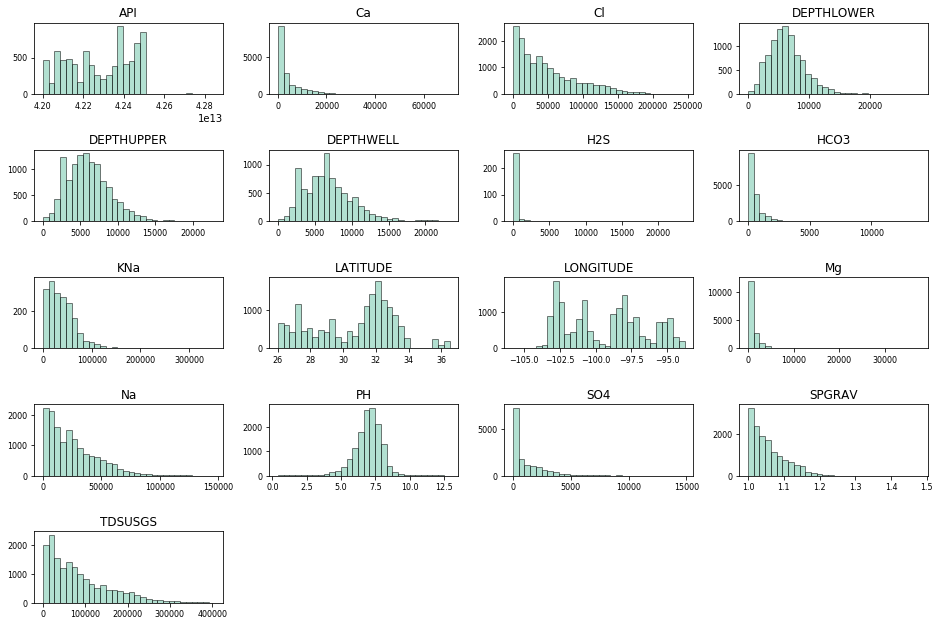

In [15]:
df_drop.hist(bins=30, alpha=0.5,edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 2.2, 2.2)) 

It is interesting to note that out of all the basins studied, the upper depths and pH form near-normal distribution profiles. Some questions to ask are about the mean of both these values:

In [16]:
print('Mean of Depth upper: ' + str(np.mean(df_drop.DEPTHUPPER)) + ' ft')
print('Mean of pH: ' + str(np.mean(df_drop.PH)))

Mean of Depth upper: 6120.011568677793 ft
Mean of pH: 6.954440942003501


C:\Users\shubh\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\shubh\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of pH in the wells')

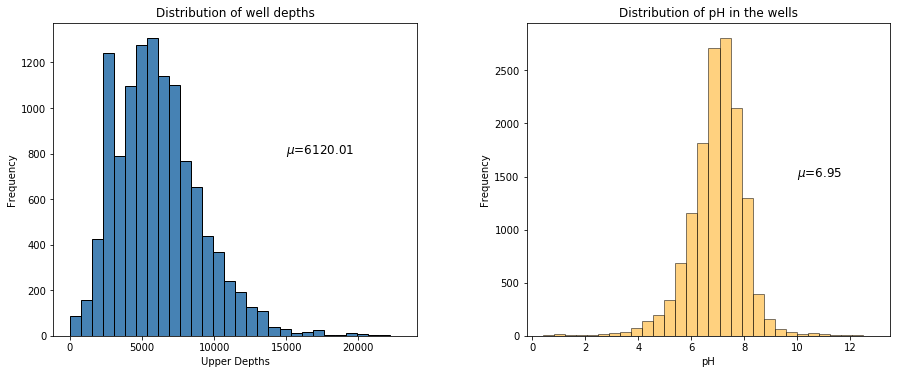

In [17]:
# examining salient features from the above graph
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Upper Depths")
ax.set_ylabel("Frequency") 
ax.text(15000, 800, r'$\mu$='+str(round(df_drop.DEPTHUPPER.mean(),2)), 
         fontsize=12)
freq, bins, patches = ax.hist(df_drop.DEPTHUPPER, color='steelblue', bins=30,
edgecolor='black', linewidth=1)
plt.title('Distribution of well depths')

ax = fig.add_subplot(1,2,2)
ax.set_xlabel("pH")
ax.set_ylabel("Frequency") 
ax.text(10, 1500, r'$\mu$='+str(round(df_drop.PH.mean(),2)), 
         fontsize=12)
freq, bins, patches = ax.hist(df_drop.PH, color='orange', bins=30, alpha=0.5,
edgecolor='black', linewidth=1)
plt.title('Distribution of pH in the wells')

Next, a general heat map of correlations was created to study any correlations.

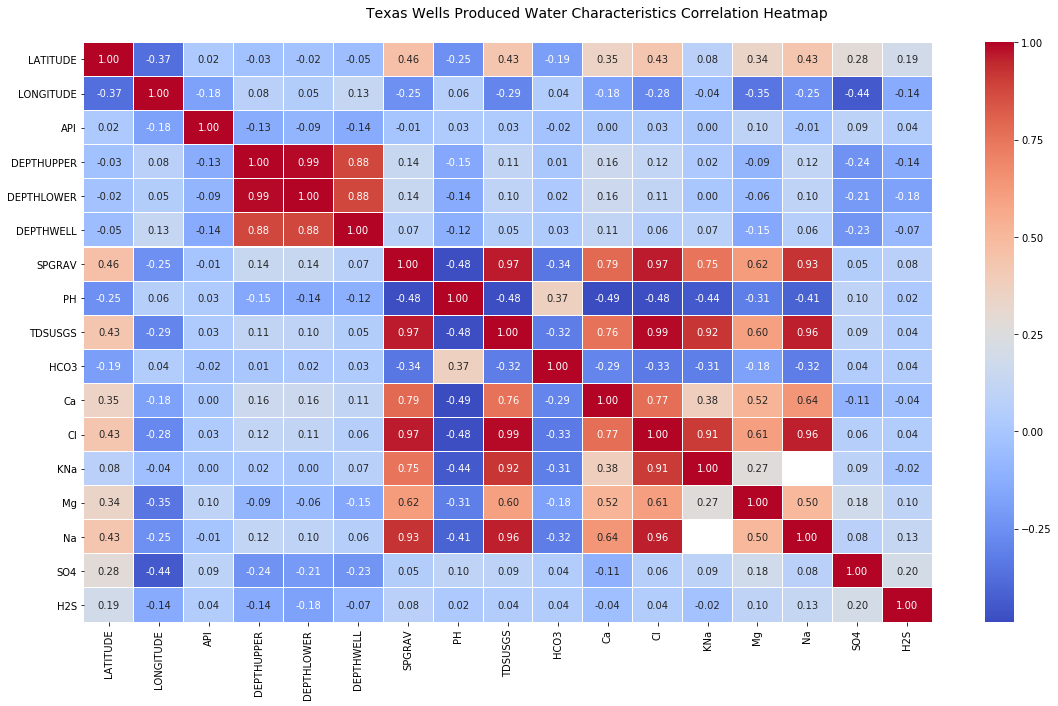

In [18]:
# Correlation Matrix Heatmap Comparisons
f, ax = plt.subplots(figsize=(19, 10))
corr = df_drop.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Texas Wells Produced Water Characteristics Correlation Heatmap', fontsize=14)

As can be seen from the heatmap above, few positive correlations are evident in the data, related to the water characteristics. The positive correlations with respect to the upper depths, lower depths (of the formations) and depths of the wells are expected. High positive correlations were also found between TDS and calcium, chlorine, potassium plus sodium, and just sodium, mostly because inclusion of these elements creates the TDS values. Magnesium and calcium don't contribute to TDS as much, which suggest that these elements are found in the insoluble phases coming out of the wells. 

It is interesting to note that the bicarbonate has a weak negative correlation with TDS, suggesting that it was found in an insoluble form. Also interesting to note is that the specific gravity of the water increases with an increase in TDS content. Chlorine was mostly found to be high in positive correlation with both potassium and sodium, suggesting it was found in aqueous soluble form as KCl or NaCl. Both sodium and chlorine have strong positive correlations with TDS and specific gravity of the produced waters. Also interesting to note is that salt content does not necessarily correlate with the depth of the wells drilled.

There is a need to study multicollinearity, and variable inflation factory analysis. This is performed below.

<div class="alert alert-warning" role="alert">
    
## Multicollinearity Analysis
</div>

In [19]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 26 columns):
LATITUDE        16631 non-null float64
LONGITUDE       16631 non-null float64
API             8172 non-null float64
BASIN           16631 non-null object
COUNTY          16622 non-null object
WELLNAME        16399 non-null object
WELLTYPE        16631 non-null object
DATECOMP        1648 non-null datetime64[ns]
DATESAMPLE      14255 non-null datetime64[ns]
FORMATION       16631 non-null object
PERIOD          16631 non-null object
DEPTHUPPER      11685 non-null float64
DEPTHLOWER      9702 non-null float64
DEPTHWELL       8843 non-null float64
SPGRAV          14357 non-null float64
PH              14225 non-null float64
TDSUSGS         16619 non-null float64
HCO3            15544 non-null float64
Ca              16561 non-null float64
Cl              16598 non-null float64
KNa             1847 non-null float64
Mg              16435 non-null float64
Na              14766 non-null

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

float_df_drop = df_drop.drop(['API','BASIN','COUNTY','WELLNAME','WELLTYPE','DATECOMP','DATESAMPLE','FORMATION','PERIOD','cull_chargeb'], axis=1)
float_df_drop = float_df_drop.fillna(0)

#Multicollinearity analysis
#Get features
feature_x = float_df_drop.drop(['TDSUSGS'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
0,227.962068,LATITUDE
1,223.686796,LONGITUDE
9,92.799579,Cl
12,46.536805,Na
5,14.708023,SPGRAV


These values are quite high, indicating presence of multicollinearity. Let us drop the variables one by one, and check again until they are below 10.

In [21]:
# Dropping LATITUDE from the df
float_df_drop = float_df_drop.drop('LATITUDE', axis=1)

#Multicollinearity analysis
#Get features
feature_x = float_df_drop.drop(['TDSUSGS'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
8,92.771078,Cl
11,46.477229,Na
0,15.053074,LONGITUDE
4,14.529205,SPGRAV
5,12.550874,PH


In [22]:
# Dropping Cl from the df
float_df_drop = float_df_drop.drop('Cl', axis=1)

#Multicollinearity analysis
#Get features
feature_x = float_df_drop.drop(['TDSUSGS'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
0,15.014701,LONGITUDE
4,14.527884,SPGRAV
5,12.534317,PH
1,9.272549,DEPTHUPPER
2,7.474073,DEPTHLOWER


In [23]:
# Dropping LONGITUDE from the df
float_df_drop = float_df_drop.drop('LONGITUDE', axis=1)

#Multicollinearity analysis
#Get features
feature_x = float_df_drop.drop(['TDSUSGS'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
3,12.936697,SPGRAV
4,10.954725,PH
0,9.063845,DEPTHUPPER
1,7.460512,DEPTHLOWER
9,3.996779,Na


In [24]:
# Dropping SPGRAV from the df
float_df_drop = float_df_drop.drop('SPGRAV', axis=1)

#Multicollinearity analysis
#Get features
feature_x = float_df_drop.drop(['TDSUSGS'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
0,9.058990,DEPTHUPPER
1,7.454160,DEPTHLOWER
8,3.775507,Na
3,3.150703,PH
5,2.985607,Ca


This looks much better now! All the values are under 10, and we can move further. We now explore these relationships further as follows, in pair-wise scatter plots:

In [25]:
float_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 12 columns):
DEPTHUPPER    16631 non-null float64
DEPTHLOWER    16631 non-null float64
DEPTHWELL     16631 non-null float64
PH            16631 non-null float64
TDSUSGS       16631 non-null float64
HCO3          16631 non-null float64
Ca            16631 non-null float64
KNa           16631 non-null float64
Mg            16631 non-null float64
Na            16631 non-null float64
SO4           16631 non-null float64
H2S           16631 non-null float64
dtypes: float64(12)
memory usage: 1.6 MB


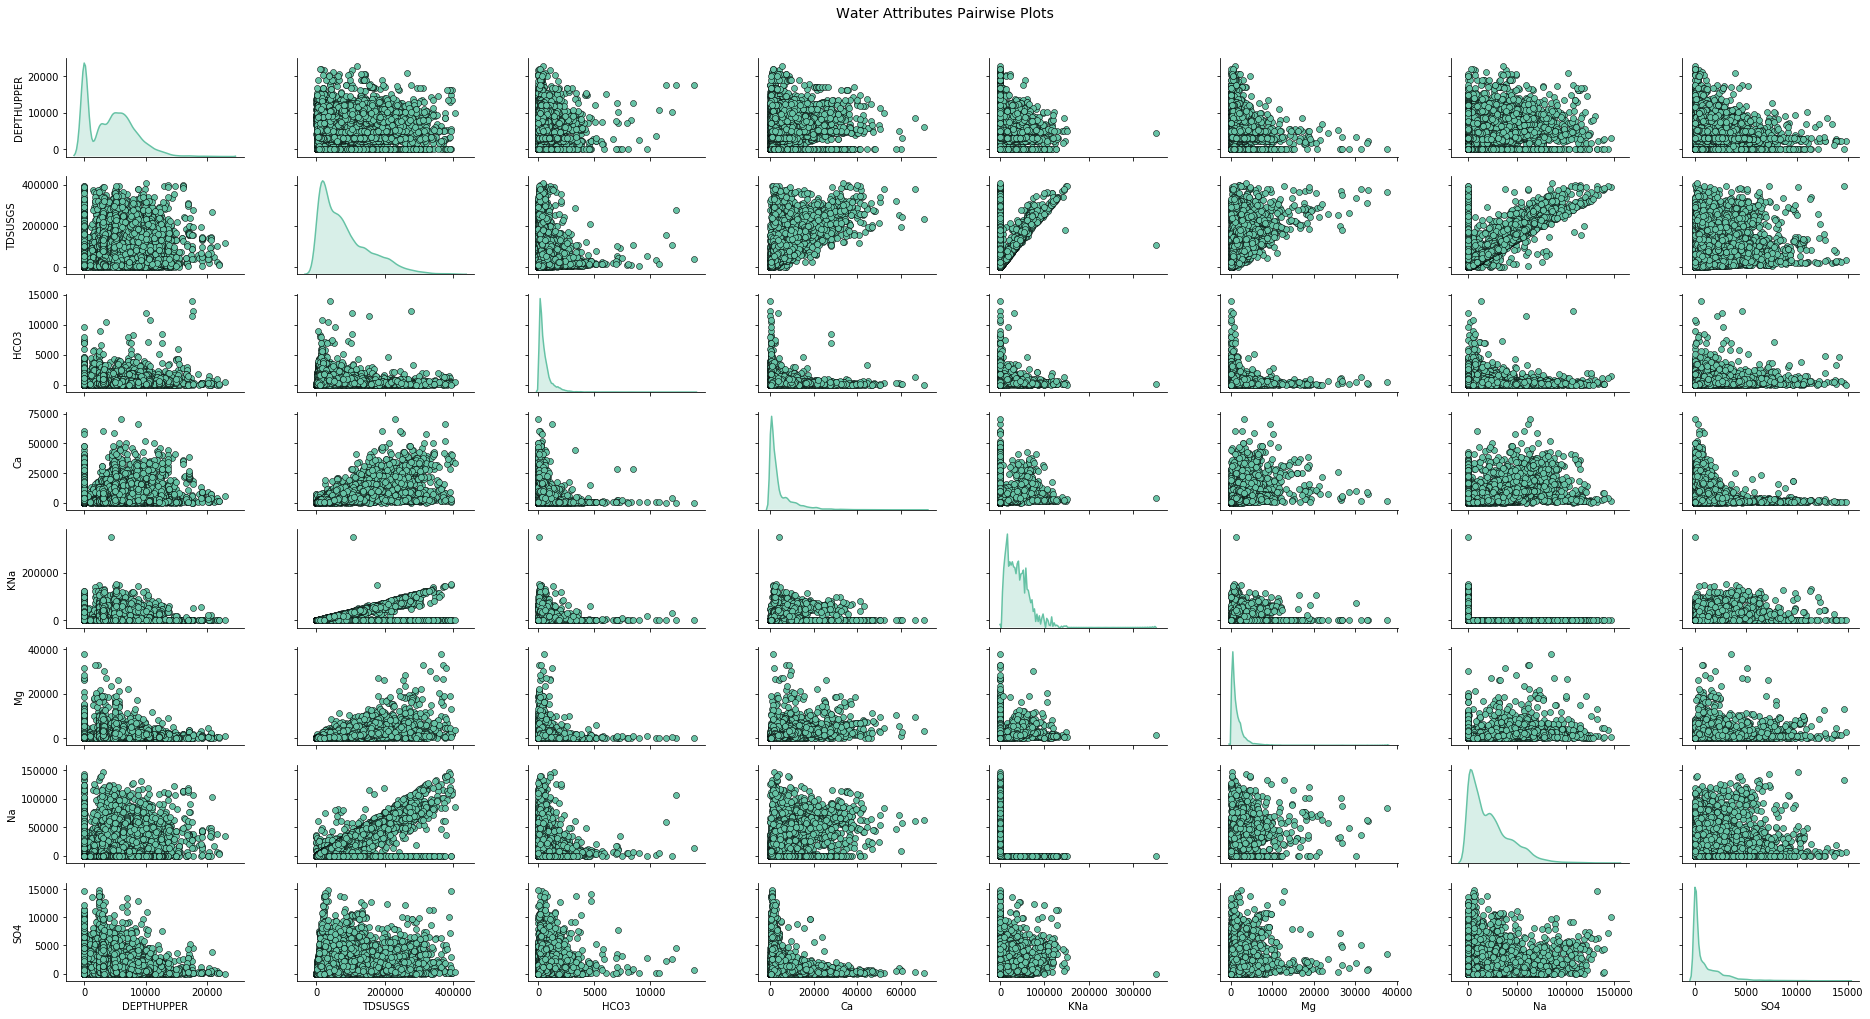

In [26]:
# Pair-wise Scatter Plots
cols = ['DEPTHUPPER', 'TDSUSGS', 'HCO3', 'Ca', 'KNa','Mg','Na', 'SO4']
pp = sns.pairplot(float_df_drop[cols], height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Water Attributes Pairwise Plots', fontsize=14)

Next, I want to study the distibutions of the TDS attribute across basins:

Wall time: 0 ns


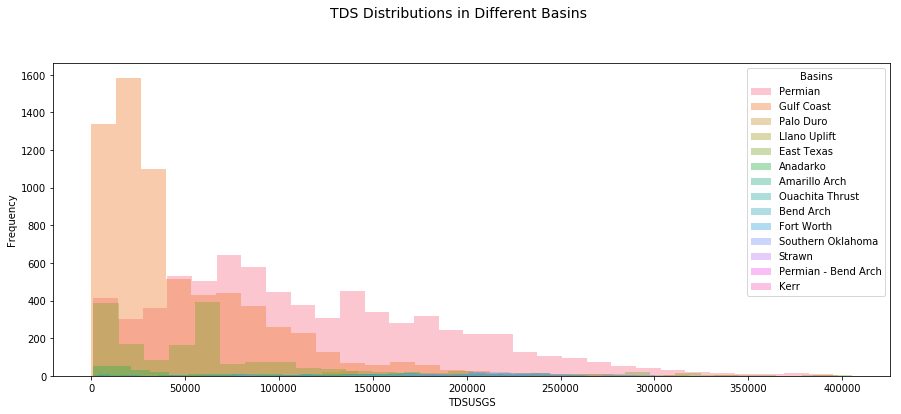

In [27]:
# Using multiple Histograms for various attributes
%time
fig = plt.figure(figsize = (15, 6))
title = fig.suptitle("TDS Distributions in Different Basins", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("TDS")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df_drop, hue='BASIN')
g.map(sns.distplot, 'TDSUSGS', kde=False, bins=30, ax=ax)
ax.legend(title='Basins')
plt.close(2)

<div class="alert alert-info" role="alert">
The distributions show that Permian Basin has a higher TDS content and spread than the other basins. The Gulf coast basin has the least amount of TDS and the least spread. More detailed information is given below. It will be interesting to note if the TDS values decrease over time in each of these basins.
</div>

Here is the above graph categorized as boxplots and as tables.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

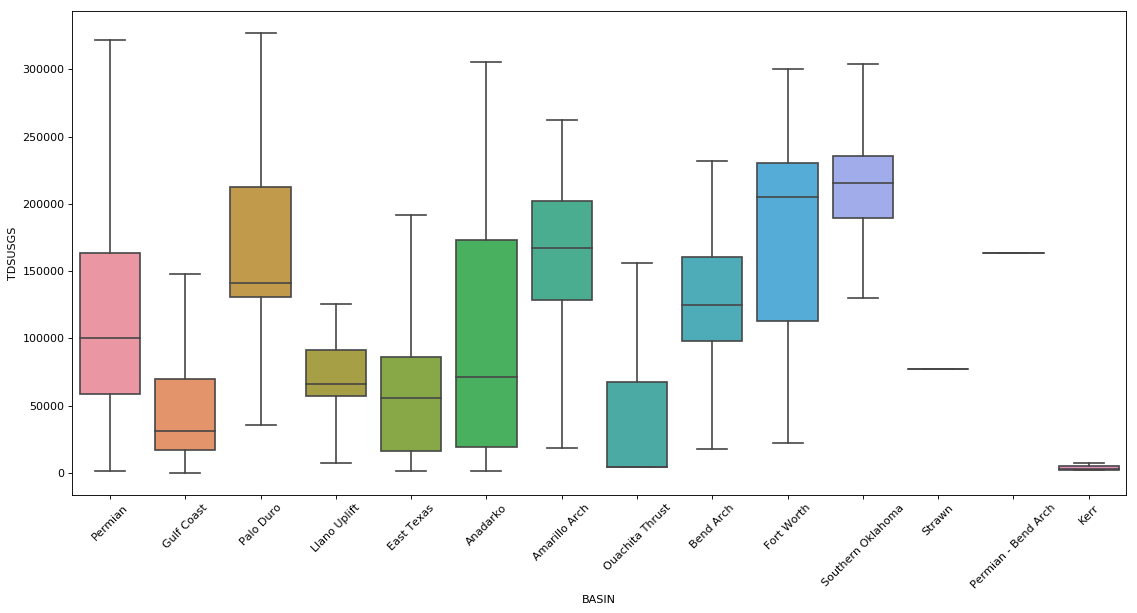

In [28]:
fig = plt.figure(num=2, figsize=(17, 8), dpi=80, facecolor='w', edgecolor='none')
ax = sns.boxplot(x='BASIN', y='TDSUSGS',data=df_drop, showfliers=False)
plt.xticks(rotation = 45)

Here are some of the aggregate details by basins.

In [29]:
df_drop.groupby('BASIN')['TDSUSGS','DEPTHUPPER','Ca','Cl','Na','Mg','KNa'].agg([np.mean,np.std])

TDSUSGS                  DEPTHUPPER               \
                              mean           std          mean          std   
BASIN                                                                         
Amarillo Arch        154548.469613  60560.340138   4468.088235  2472.812127   
Anadarko              96739.942693  84377.103311   7257.771429  2508.597384   
Bend Arch            130140.378049  49314.089034   3520.676056  1103.744688   
East Texas            70701.400585  71027.741332   5958.270538  2549.456411   
Fort Worth           179400.761905  72928.075503   5057.904110  1489.351473   
Gulf Coast            48086.485359  46451.353431   6346.085068  2912.395088   
Kerr                   3790.000000   2354.170059  13913.000000     0.000000   
Llano Uplift          65233.225000  34543.503899   2764.206897   726.176257   
Ouachita Thrust       45087.800000  64232.602004   3082.769231  1453.099340   
Palo Duro            166651.079646  55620.246012   4973.470588  1683.458879   
Permian              114898.115067  74255.824223   5994.808014  3119.839273   
Permian - Bend Arch  163735.000000           NaN  10554.000000          NaN   
Southern Oklahoma    209243.619718  48716.796947   4752.782258  1644.669495   
Strawn                76863.000000           NaN   2900.000000          NaN   

                               Ca                          Cl                \
                             mean          std           mean           std   
BASIN                                                                         
Amarillo Arch         9037.291934  4955.320584   94421.123702  37310.773908   
Anadarko              5282.309856  6425.865704   58674.592931  52477.966806   
Bend Arch             9183.900122  5871.150910   80004.031951  30951.788216   
East Texas            4555.364577  8483.886971   42519.505132  44405.799112   
Fort Worth           15622.517738  9825.109323  109837.553452  44782.232401   
Gulf Coast            2002.337335  3991.621070   28595.236278  28756.685826   
Kerr                   130.000000   180.000000    1222.500000   1406.926319   
Llano Uplift          4323.105750  4548.205201   39452.964500  21443.799846   
Ouachita Thrust       4061.553333  7286.926581   26322.712667  40106.044150   
Palo Duro            11537.991150  8379.840293  101678.014690  34895.902553   
Permian               6052.976917  6402.730651   68862.103831  46228.043174   
Permian - Bend Arch  34650.000000          NaN   88200.000000           NaN   
Southern Oklahoma    19082.492958  5165.420367  130176.736809  29081.893656   
Strawn                3333.000000          NaN   47039.290000           NaN   

                               Na                         Mg               \
                             mean           std         mean          std   
BASIN                                                                       
Amarillo Arch        47806.631111  18593.483490  2223.481117  1380.606272   
Anadarko             30027.049275  26083.663520  1155.553295  1993.504252   
Bend Arch            38036.855122  12949.388866  1859.509756  1222.765386   
East Texas           21472.806176  18651.711461   530.299824   924.770410   
Fort Worth           50134.466386  20290.949556  2663.641071  2840.675742   
Gulf Coast           15708.288095  14282.875046   272.062544   477.347153   
Kerr                  1210.000000    724.292758          NaN          NaN   
Llano Uplift         19425.259250   9816.387117   861.152250   433.331034   
Ouachita Thrust      12034.264286  18337.804838   635.178667   862.754530   
Palo Duro            47940.032936  14986.708349  2356.447522  1289.776325   
Permian              34393.895490  22201.504573  1832.960588  2377.524732   
Permian - Bend Arch  11601.000000           NaN  3217.000000          NaN   
Southern Oklahoma    56007.790355  13505.639203  3502.160352   950.986746   
Strawn               25514.120000           NaN   589.750000          NaN   

                             

The table above points out several main observations, and corroborates the findings from the previous histograms. The basin with the highest TDS content is Southern Oklahoma, followed by Fort Worth and then Palo Duro. The standard deviation of TDS in the Permian basin is about 65% of the mean, and that the highest TDS spreads are noticeable for Anadarko, Permian and Fort Worth. The most hard waters (higher Ca and Mg content) are found in the Southern Oklahoma, Fort Worth and Palo Duro basins, and these waters respectively have the highest Na and Cl concentrations as well. 

It is also interesting to note that Permian has the highest variability in terms of depths of wells drilled, followed by Gulf coast, East Texas, Anadarko and then Amarillo. 

Running a comparative distribution profile on the depths:

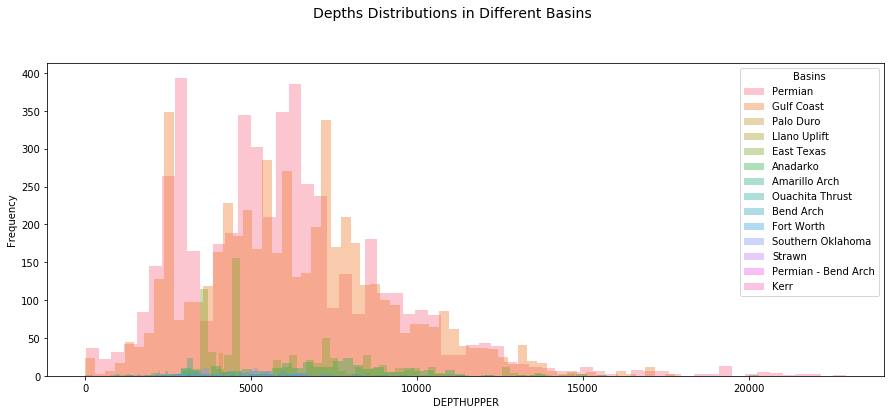

In [30]:
# Using multiple Histograms for various attributes
fig = plt.figure(figsize = (15, 6))
title = fig.suptitle("Depths Distributions in Different Basins", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Depths")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df_drop, hue='BASIN')
g.map(sns.distplot, 'DEPTHUPPER',kde=False, bins=60, ax=ax)
ax.legend(title='Basins')
plt.close(2)

<div class="alert alert-warning" role="alert">

## Time Series Analyses
</div>

The current dataset also holds information of these produced waters taken over different time periods. The sampling dates and years did not necessarily show many patterns (analysis not shown). Certain hypotheses can be tested as to the rates of mineral or TDS change over time, by each basin. The following procedure looks at this question.

First, I converted the DATESAMPLE parameter into elapsed time from the first noted observation. **It is important to note that the first recorded observation does not necessarily imply that the well was drilled then.** 

In [31]:
#need to change the dates into elapsed time
for x, dfmini in enumerate(filled_depths):
    
    if len(dfmini) > 1:
        first_obs = dfmini.DATESAMPLE.min()
        #print(filled_depths[x].DATESAMPLE)
        filled_depths[x]['ElapsedTime'] = (filled_depths[x].DATESAMPLE - first_obs)
            
        filled_depths[x]['ElapsedTime'] = filled_depths[x]['ElapsedTime'].dt.days
        #print('after' + str(filled_depths[x].ElapsedTime))
    else:
        filled_depths[x]['ElapsedTime'] = 0
        #print(filled_depths[x].ElapsedTime)

Next, I tried to plot the TDS change over the elapsed time intervals for each mini-dataframe in the *filled_depths* list. The results were quite ugly, as shown below and a better way to summarize these results needed to be analyzed.

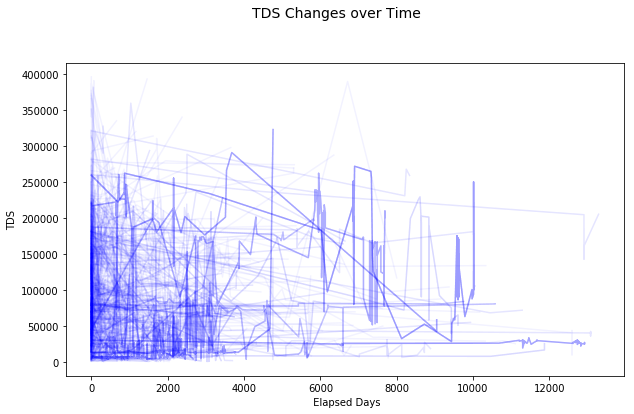

In [32]:
fig = plt.figure(figsize = (10, 6))
title = fig.suptitle("TDS Changes over Time", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
plt.xlabel(' Elapsed Days')
plt.ylabel('TDS')

for x, dfmini in enumerate(filled_depths):
    if len(dfmini) > 1:

        dfmini.sort_values('ElapsedTime', inplace=True)
        ax.plot(dfmini.ElapsedTime,dfmini.TDSUSGS, color='b', alpha=0.05)
        

I then decided to look at the rate of overall change of different nutrients, as approximated using linear least squares fit. The following procedure outlines the steps:

<div class="alert alert-info">
1. Initialize empty lists for storing the slopes of each of the water parameters TDS, Ca, Cl, KNa, Na and Mg. <br>
2. For wells with more than one DATESAMPLE, append the slope of line going through y = nutrient concentration, and x = elapsed time, in the respective lists.
</div>

In [33]:
#analyzing the rates of TDS decline/increase across basins

ratesTDS = []
ratesCa = []
ratesCl = []
ratesKNa = []
ratesMg = []
ratesNa = []
basininfo = []

for x, dfmini in enumerate(filled_depths):
    if len(dfmini) > 1:
        if dfmini.ElapsedTime[1] != 0:
            if dfmini.ElapsedTime.isnull().any():
                next
            else:
                basininfo.append(dfmini.BASIN[0])
                ratesTDS.append(linregress(dfmini.ElapsedTime, dfmini.TDSUSGS).slope)
                ratesCa.append(linregress(dfmini.ElapsedTime, dfmini.Ca).slope)
                ratesCl.append(linregress(dfmini.ElapsedTime, dfmini.Cl).slope)
                ratesKNa.append(linregress(dfmini.ElapsedTime, dfmini.KNa).slope)
                ratesMg.append(linregress(dfmini.ElapsedTime, dfmini.Mg).slope)
                ratesNa.append(linregress(dfmini.ElapsedTime, dfmini.Na).slope)

C:\Users\shubh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\shubh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\shubh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The different lists were then zipped and collated into a dataframe called *ratesTotal*. This dataframe has the rates of change of the different observations (in units of mg/L/day).

In [34]:
# rates of change (mg/L/day)
ratesTotal = pd.DataFrame(zip(basininfo,ratesTDS,ratesCa,ratesCl,ratesKNa,ratesMg,ratesNa),columns=['Basin','TDS','Ca','Cl','KNa','Mg','Na'])
ratesTotal.head(10)

,Basin,TDS,Ca,Cl,KNa,Mg,Na
0,Permian,4.236655,-0.201626,3.094107,NaN,0.742126,0.772040
1,Permian,-236.082569,-9.625872,-143.123394,NaN,-3.094587,-77.386881
2,Permian,-107.683443,-4.190995,-65.415020,NaN,-1.392798,-35.554246
3,Permian,-165.096203,-12.007897,-98.750181,NaN,-2.070093,-51.510459
4,Permian,-1.752174,0.298551,-1.068899,NaN,-0.119014,-0.807275
5,Permian,-93.063063,-4.981982,-57.864955,NaN,-1.493243,-28.968468
6,Permian,-3.154519,-0.527697,-1.903265,NaN,0.034636,-0.731195
7,Permian,-115.194175,-3.781553,-71.277961,NaN,-0.898350,-39.927427
8,Permian,-60.041270,-3.339683,-38.043048,NaN,-2.006254,-16.924317
9,Permian,24.437599,3.930490,7.608878,NaN,0.431311,4.751611


To get a better idea of these rates, I am characterizing the different slopes according to the basins using boxplots.

Text(0, 0.5, 'Rates of Depletion (mg/L/d)')

<Figure size 1600x560 with 0 Axes>

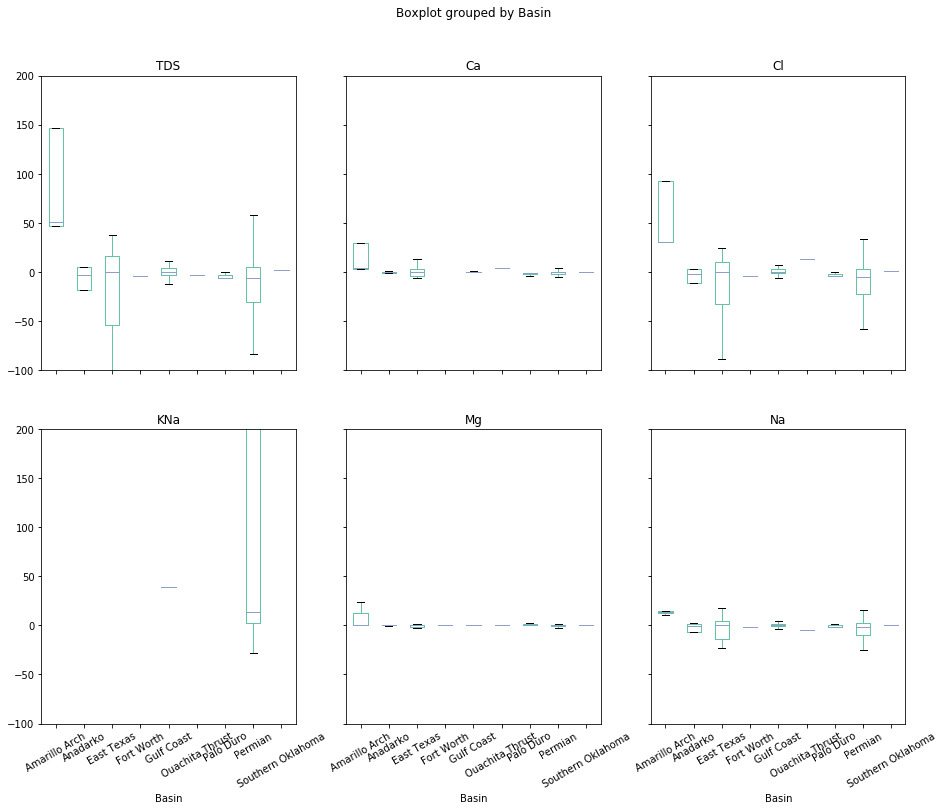

In [35]:
plt.figure(figsize=(20, 7), dpi=80, facecolor='w', edgecolor='none')

ratesTotal.boxplot(column=['TDS','Ca','Cl','KNa','Mg','Na'],by='Basin',rot=30,figsize=(15,12),layout=(2,3),grid=False,showfliers=False)

plt.ylim(-100,200)
plt.ylabel('Rates of Depletion (mg/L/d)')

One can even look at these results in detail using a tabulated *groupby* command. 

In [36]:
ratesTotal.groupby('Basin')['TDS','Ca','Cl','KNa','Mg','Na'].median()

,TDS,Ca,Cl,KNa,Mg,Na
Basin,,,,,,
Amarillo Arch,50.830134,3.452484,30.393916,NaN,0.844693,13.460757
Anadarko,-2.797358,-0.612686,-1.913080,NaN,-0.082409,-0.932909
East Texas,0.277651,-0.010937,0.185471,NaN,-0.001319,0.178240
Fort Worth,-4.000000,-200.800000,-4.000000,NaN,0.200000,-2.000000
Gulf Coast,0.243283,0.011417,-0.034633,39.337748,0.009768,0.142724
Ouachita Thrust,-3.430108,3.726828,13.308065,NaN,0.298172,-4.437204
Palo Duro,-6.360527,-0.639789,-3.921916,NaN,-0.127088,-1.569361
Permian,-6.406061,-0.396274,-4.878076,13.914785,-0.090247,-1.668161
Southern Oklahoma,1.497137,0.004771,0.937853,NaN,0.138302,0.364866


<div class="alert alert-info" role="alert">
Based on these plots and table, many inferences can be made. The TDS seems to increase for Amarillo Arch and Southern Oklahoma basins at about 50.8 mg/L/day and 1.5 mg/L/day, respectively. Other basins including Permian, Palo Duro, Ouachita Thrust and Anadarko all decrease over time in TDS concentrations. Fort Worth has a very rapid decline in calcium concentrations, but that could be an outlier. The Ouachita Thrust basin saw an increase in calcium and chlorine concentrations, while an overall decrease in TDS concentrations. This may be due to presence of insoluble calcium chloride, or other insoluble forms of both calcium and chlorine. Sodium and chlorine otherwise mimicked TDS patterns quite closely across basins. 
</div>

<div class="alert alert-warning" role="alert">

### Bootstrapping depths to understand how basins compare
</div>

To really understand the spread of depths associated by basins, a bootstrapping test was performed on each of the basins. First the rows belonging to each basin were filtered out, and then a 1000 sample bootstrap was computed using their median values, as follows:

In [37]:
#defining the bootstrap and ecdf functions here
def draw_bs_samples(data, func, size=1):
    """The function takes in 1-D NumPy array, a function and the number of iterations to return a computed bootstrapped
    list of values (list of lists) bs_samples"""
    bs_samples = []
    
    for i in range(size):
        rand_sample = np.random.choice(data, len(data))
        bs_samples.append(rand_sample)
        
    return bs_samples

In [38]:
permian_bs = draw_bs_samples(permian.TDSUSGS,np.median,1000)
amarillo_bs = draw_bs_samples(amarillo.TDSUSGS,np.median,1000)
anadarko_bs = draw_bs_samples(anadarko.TDSUSGS,np.median,1000)
eastTexas_bs = draw_bs_samples(eastTexas.TDSUSGS,np.median,1000)
paloDuro_bs = draw_bs_samples(paloDuro.TDSUSGS,np.median,1000)
southernOklahoma_bs = draw_bs_samples(southernOklahoma.TDSUSGS,np.median,1000)
fortWorth_bs = draw_bs_samples(fortWorth.TDSUSGS,np.median,1000)

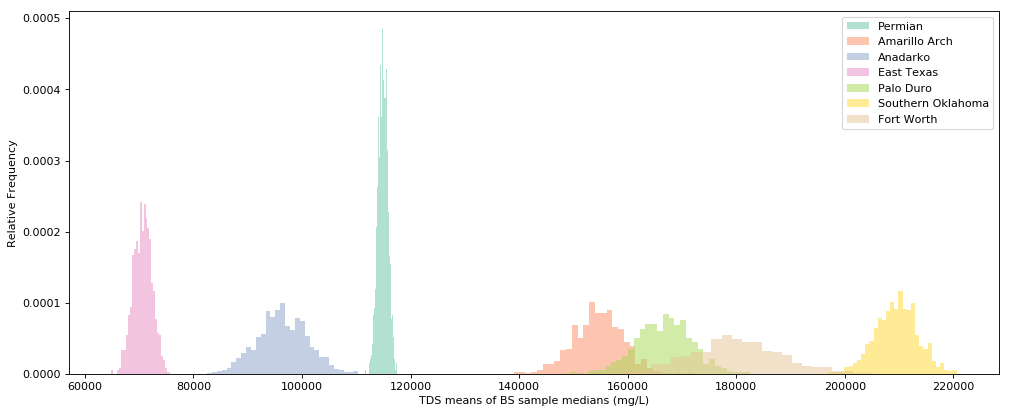

In [39]:
fig = plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='none')
permian_medians = []
for i in permian_bs:
    permian_medians.append(np.mean(i))
_ = plt.hist(permian_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='Permian')

amarillo_medians = []
for i in amarillo_bs:
    amarillo_medians.append(np.mean(i))
_ = plt.hist(amarillo_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='Amarillo Arch')

anadarko_medians = []
for i in anadarko_bs:
    anadarko_medians.append(np.mean(i))
_ = plt.hist(anadarko_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='Anadarko')

eastTexas_medians = []
for i in eastTexas_bs:
    eastTexas_medians.append(np.mean(i))
_ = plt.hist(eastTexas_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='East Texas')

paloDuro_medians = []
for i in paloDuro_bs:
    paloDuro_medians.append(np.mean(i))
_ = plt.hist(paloDuro_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='Palo Duro')

southernOklahoma_medians = []
for i in southernOklahoma_bs:
    southernOklahoma_medians.append(np.mean(i))
_ = plt.hist(southernOklahoma_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='Southern Oklahoma')

fortWorth_medians = []
for i in fortWorth_bs:
    fortWorth_medians.append(np.mean(i))
_ = plt.hist(fortWorth_medians, bins = int(np.sqrt(1000)), alpha=0.5, density=True, label='Fort Worth')

plt.xlabel('TDS means of BS sample medians (mg/L)')
plt.ylabel('Relative Frequency')

plt.legend()

<div class="alert alert-warning" role="alert">

### Pre- and Post-Permian Oil Shale Revolution TDS Statistical Comparison
</div>

From the previous graph, it seems that the Permian basin has the least spread, and it is not as full of TDS as 4 other major basins. Comparing these values with post-Permian oil shale revolution TDS values for the Permian basin, we can test a hypothesis whether the pre-oil shale revolution Permian TDS values were significantly different from post-oil shale revolution Permian TDS values. 

There is not a whole lot of data publicly available for produced water, especially considering the controversies surrounding hydraulic fracturing. However, bootstrapping 8 samples from 2016 helped generate results in the post-Permian oil shale revolution. The data has been obtained from the reference below. 

<i> (Khan, N. A., Engle, M., Dungan, B., Holguin, F. O., Xu, P., & Carroll, K. C. (2016). Volatile-organic molecular characterization of shale-oil produced water from the Permian Basin. Chemosphere, 148, 126–136. doi:10.1016/j.chemosphere.2015.12.116) </i>

We will run a bootstrap test on the 8 samples that the researchers collected from the Permian Basin, after establishing the values in a new dataframe *ref_TDS_df*. Then we plot the two together.

In [40]:
ref_TDS = np.array([106540,113760,116370,105030,119083,114830,162880,142630])
ref_TDS

array([106540, 113760, 116370, 105030, 119083, 114830, 162880, 142630])

In [41]:
ref_permian_bs = draw_bs_samples(ref_TDS,np.median,10000)
permian_bs1 = draw_bs_samples(permian.TDSUSGS,np.median,10000)

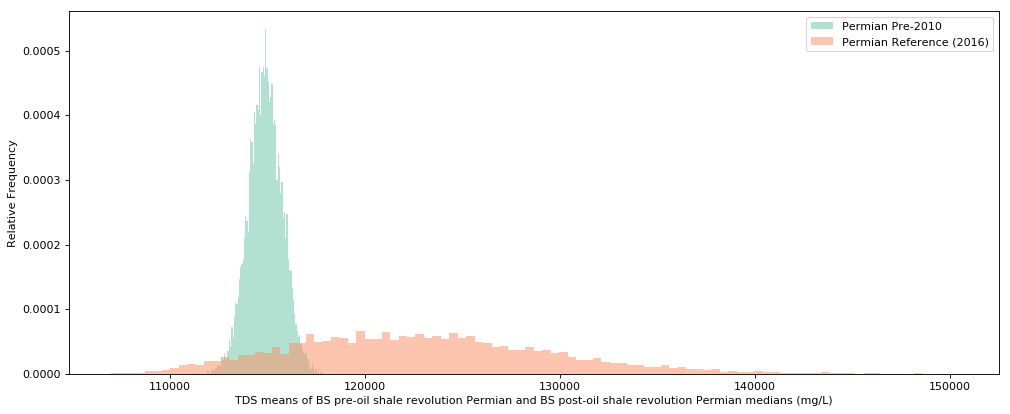

In [42]:
fig = plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='none')
permian_medians = []
for i in permian_bs1:
    permian_medians.append(np.mean(i))
_ = plt.hist(permian_medians, bins = int(np.sqrt(10000)), alpha=0.5, density=True, label='Permian Pre-2010')

ref_medians = []
for i in ref_permian_bs:
    ref_medians.append(np.mean(i))
_ = plt.hist(ref_medians, bins = int(np.sqrt(10000)), alpha=0.5, density=True, label='Permian Reference (2016)')


plt.xlabel('TDS means of BS pre-oil shale revolution Permian and BS post-oil shale revolution Permian medians (mg/L)')
plt.ylabel('Relative Frequency')

plt.legend()

The null hypothesis is that the two means are the same, and we will use the z-test for calculating the p-values. 

In [43]:
#Checking using the z-score/frequentist method
z = (np.mean(ref_medians) - np.mean(permian_medians))/(np.sqrt((np.var(ref_medians)+np.var(permian_medians))/10000))
print('The z-score of the difference of the two means is {}'.format(z))

The z-score of the difference of the two means is 119.17367616559825


In [44]:
#Checking using the manual method
diff_pop = np.array(ref_medians) - np.array(permian_medians)
diff_sam = np.mean(ref_TDS) - np.mean(permian.TDSUSGS)
p = np.sum(np.mean(diff_pop) >= diff_sam)/10000
print('The p-value of the difference of the two means is {}'.format(p))

The p-value of the difference of the two means is 0.0001


<div class="alert alert-info" role="alert">
At this z-score, the p-value is very low, and hence the null hypothesis can be rejected safely, and said that the TDS did infact increase after the shale oil revolution. This can be attributed to the drilling of more horizontal wells with more minerals and salts seeping in. Addition of frac fluids can also be a major cause of an increase in the TDS and salt content of the produced waters.
</div>

# Machine Learning Models 

In [45]:
# The main features of the dataset again
float_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 12 columns):
DEPTHUPPER    16631 non-null float64
DEPTHLOWER    16631 non-null float64
DEPTHWELL     16631 non-null float64
PH            16631 non-null float64
TDSUSGS       16631 non-null float64
HCO3          16631 non-null float64
Ca            16631 non-null float64
KNa           16631 non-null float64
Mg            16631 non-null float64
Na            16631 non-null float64
SO4           16631 non-null float64
H2S           16631 non-null float64
dtypes: float64(12)
memory usage: 2.3 MB


### Roadmap for machine learning problem:
<div class="alert alert-info "alert">
1. Solve for Ca and Na using median imputation. <br>
2. Create test/train data, Create model to solve for depthupper using lat, lon, basin, welltype, Cl, Ca, Na and TDS. <br>
</div>

In [46]:
#******* Step 1: solving for Cl, Ca and Na using median imputation (done here because the spread was not substantial)

float_df_drop['Ca'].replace(0, float_df_drop['Ca'].median(), inplace=True)
float_df_drop['Na'].replace(0, float_df_drop['Na'].median(), inplace=True)

In [47]:
# Creating dummies for the two categories 
basin_dummy = pd.get_dummies(df_drop['BASIN'], drop_first=True, prefix='basin')
welltype_dummy = pd.get_dummies(df_drop['WELLTYPE'], drop_first=True, prefix='welltype')

In [48]:
# Joining the dummy variables
float_df_drop = float_df_drop.join(basin_dummy).join(welltype_dummy)

In [49]:
# Dropping the depthwell as it has lots of null values
float_df_drop.drop('DEPTHWELL', axis=1, inplace=True)

In [50]:
float_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 26 columns):
DEPTHUPPER                   16631 non-null float64
DEPTHLOWER                   16631 non-null float64
PH                           16631 non-null float64
TDSUSGS                      16631 non-null float64
HCO3                         16631 non-null float64
Ca                           16631 non-null float64
KNa                          16631 non-null float64
Mg                           16631 non-null float64
Na                           16631 non-null float64
SO4                          16631 non-null float64
H2S                          16631 non-null float64
basin_Anadarko               16631 non-null uint8
basin_Bend Arch              16631 non-null uint8
basin_East Texas             16631 non-null uint8
basin_Fort Worth             16631 non-null uint8
basin_Gulf Coast             16631 non-null uint8
basin_Kerr                   16631 non-null uint8
basin_Llano Uplift 

In [51]:
# Now trying the StandardScaler with the data  
from sklearn.preprocessing import MinMaxScaler

idx = float_df_drop.index

scaler = MinMaxScaler()

float_df_drop_scaled = scaler.fit_transform(float_df_drop[['DEPTHUPPER','DEPTHLOWER','PH','HCO3','Ca','KNa','Mg','Na','SO4','H2S']])

In [52]:
# Converting array to df
float_df_drop_scaled_df = pd.DataFrame(float_df_drop_scaled, columns=['DEPTHUPPER','DEPTHLOWER','PH','HCO3','Ca','KNa','Mg','Na','SO4','H2S'], index=idx)

In [53]:
# Joining the two scaled and unscaled vars
float_df_drop_total = float_df_drop.join(float_df_drop_scaled_df, rsuffix='_scaled')
float_df_drop_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 36 columns):
DEPTHUPPER                   16631 non-null float64
DEPTHLOWER                   16631 non-null float64
PH                           16631 non-null float64
TDSUSGS                      16631 non-null float64
HCO3                         16631 non-null float64
Ca                           16631 non-null float64
KNa                          16631 non-null float64
Mg                           16631 non-null float64
Na                           16631 non-null float64
SO4                          16631 non-null float64
H2S                          16631 non-null float64
basin_Anadarko               16631 non-null uint8
basin_Bend Arch              16631 non-null uint8
basin_East Texas             16631 non-null uint8
basin_Fort Worth             16631 non-null uint8
basin_Gulf Coast             16631 non-null uint8
basin_Kerr                   16631 non-null uint8
basin_Llano Uplift 

In [54]:
# Removing the unscaled variables
float_scaled = float_df_drop_total.drop(['DEPTHUPPER','DEPTHLOWER','PH','HCO3','Ca','KNa','Mg','Na','SO4','H2S'], axis=1)
float_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16631 entries, 0 to 19386
Data columns (total 26 columns):
TDSUSGS                      16631 non-null float64
basin_Anadarko               16631 non-null uint8
basin_Bend Arch              16631 non-null uint8
basin_East Texas             16631 non-null uint8
basin_Fort Worth             16631 non-null uint8
basin_Gulf Coast             16631 non-null uint8
basin_Kerr                   16631 non-null uint8
basin_Llano Uplift           16631 non-null uint8
basin_Ouachita Thrust        16631 non-null uint8
basin_Palo Duro              16631 non-null uint8
basin_Permian                16631 non-null uint8
basin_Permian - Bend Arch    16631 non-null uint8
basin_Southern Oklahoma      16631 non-null uint8
basin_Strawn                 16631 non-null uint8
welltype_Tight Gas           16631 non-null uint8
welltype_Tight Oil           16631 non-null uint8
DEPTHUPPER_scaled            16631 non-null float64
DEPTHLOWER_scaled            16631 no

<div class="alert alert-info" role="alert">
    
### Testing out the Different Models for the Scaled Dataset

</div>

In [55]:
# Importing the libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Separating out the X and y for training and testing
X = float_scaled.drop('TDSUSGS', axis=1)
y = float_scaled['TDSUSGS']

# Training and test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
X_train.isnull().sum()

basin_Anadarko               0
basin_Bend Arch              0
basin_East Texas             0
basin_Fort Worth             0
basin_Gulf Coast             0
basin_Kerr                   0
basin_Llano Uplift           0
basin_Ouachita Thrust        0
basin_Palo Duro              0
basin_Permian                0
basin_Permian - Bend Arch    0
basin_Southern Oklahoma      0
basin_Strawn                 0
welltype_Tight Gas           0
welltype_Tight Oil           0
DEPTHUPPER_scaled            0
DEPTHLOWER_scaled            0
PH_scaled                    0
HCO3_scaled                  0
Ca_scaled                    0
KNa_scaled                   0
Mg_scaled                    0
Na_scaled                    0
SO4_scaled                   0
H2S_scaled                   0
dtype: int64

In [57]:
# OLS Regression
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)
y_pred_lm = lm.predict(X_test)
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lm))
print('The OLS regression R^2 value for the train data is {}'.format(lm.score(X_train, y_train)))
print('The OLS regression R^2 value for the test data is {}'.format(lm.score(X_test, y_test)))
print('The OLS RMSE is {}'.format(lm_rmse))

The OLS regression R^2 value for the train data is 0.9750831699986127
The OLS regression R^2 value for the test data is 0.9572366807770428
The OLS RMSE is 14944.298436446912


These are amazing results, and proves that our model has very good fit or R^2 value. We can use this model as is, without hyperparameter tuning. But we will look at a few other models, and check feature importances.

Usually, if we are not satisfied by our model, we would check if the number of samples is less than 100,000. If no, we would try the SGD regression; if yes, we would try the Lasso and Ridge regression, or the SVR with a linear kernel. If that doesn't work, we can move on to rbf kernels on the SVR and other ensemble methods like the Random Forests.

In [58]:
# Trying out different models
# Lasso regression with dummy vars

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print('The Lasso regression R^2 value for the train data is {}'.format(lasso.score(X_train, y_train)))
print('The Lasso regression R^2 value for the test data is {}'.format(lasso.score(X_test, y_test)))
print('The Lasso RMSE is {}'.format(lasso_rmse))

The Lasso regression R^2 value for the train data is 0.975083072550928
The Lasso regression R^2 value for the test data is 0.957244071768732
The Lasso RMSE is 14943.00693288142


In [59]:
#Lasso regression with dummy vars
from sklearn.linear_model import Ridge

#y_train = np.array(y_train).reshape(-1,1)
ridge = Ridge(alpha=0.1, max_iter=10000)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print('The Ridge regression R^2 value for the train data is {}'.format(ridge.score(X_train, y_train)))
print('The Ridge regression R^2 value for the test data is {}'.format(ridge.score(X_test, y_test)))
print('The Ridge RMSE is {}'.format(ridge_rmse))

The Ridge regression R^2 value for the train data is 0.9750790045468527
The Ridge regression R^2 value for the test data is 0.9575364787599296
The Ridge RMSE is 14891.821797132421


In [60]:
#Stochastic Gradient Descent Regressor
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, eta0=0.1)
sgd_reg.fit(X_train, y_train)
y_pred_sgd = sgd_reg.predict(X_test)
sgd_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sgd))
print('The Stochastic Gradient Descent regression R^2 value for the train data is {}'.format(sgd_reg.score(X_train, y_train)))
print('The Stochastic Gradient Descent regression R^2 value for the test data is {}'.format(sgd_reg.score(X_test, y_test)))
print('The Stochastic Gradient Descent RMSE is {}'.format(sgd_rmse))

The Stochastic Gradient Descent regression R^2 value for the train data is 0.974341842390608
The Stochastic Gradient Descent regression R^2 value for the test data is 0.9601810892993692
The Stochastic Gradient Descent RMSE is 14420.639357659811


In [61]:
#Support Vector Machines Linear
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=.01)
svm_reg.fit(X_train, y_train)
y_pred_svm = svm_reg.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print('The SVM regression R^2 value for the train data is {}'.format(svm_reg.score(X_train, y_train)))
print('The SVM regression R^2 value for the test data is {}'.format(svm_reg.score(X_test, y_test)))
print('The SVM RMSE is {}'.format(svm_rmse))

The SVM regression R^2 value for the train data is -0.8785469720818369
The SVM regression R^2 value for the test data is -0.8804122053989203
The SVM RMSE is 99098.33527732459


In [62]:
#Support Vector Machines Polynomial
from sklearn.svm import SVR

polysvr_reg = SVR(kernel='rbf', degree=2,C=100,epsilon=1)
polysvr_reg.fit(X_train, y_train)
y_pred_polysvr = polysvr_reg.predict(X_test)
polysvr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_polysvr))
print('The RBF SVM regression R^2 value for the train data is {}'.format(polysvr_reg.score(X_train, y_train)))
print('The RBF SVM regression R^2 value for the test data is {}'.format(polysvr_reg.score(X_test, y_test)))
print('The RBF SVM RMSE is {}'.format(polysvr_rmse))

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The RBF SVM regression R^2 value for the train data is 0.06890863742667919
The RBF SVM regression R^2 value for the test data is 0.08409922140599801
The RBF SVM RMSE is 69161.44243149617


In [63]:
#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

dec_reg = DecisionTreeRegressor(max_depth=15)
dec_reg.fit(X_train, y_train.ravel())
y_pred_dec = dec_reg.predict(X_test)
dec_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dec))
print('The Decision Tree regression R^2 value for the train data (at depth = 15) is {}'.format(dec_reg.score(X_train, y_train)))
print('The Decision Tree regression R^2 value for the test data (at depth = 15) is {}'.format(dec_reg.score(X_test, y_test)))
print('The Decision Tree RMSE is {}'.format(dec_rmse))

The Decision Tree regression R^2 value for the train data (at depth = 15) is 0.999503167801725
The Decision Tree regression R^2 value for the test data (at depth = 15) is 0.9632363281673717
The Decision Tree RMSE is 13856.36352437888


In [64]:
#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=20, n_estimators=100)
rf_reg.fit(X_train, y_train.ravel())
y_pred_rf = rf_reg.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print('The Random Forest regression R^2 value for the train data (at depth = 20) is {}'.format(rf_reg.score(X_train, y_train)))
print('The Random Forest regression R^2 value for the test data (at depth = 20) is {}'.format(rf_reg.score(X_test, y_test)))
print('The Random Forest RMSE is {}'.format(rf_rmse))

The Random Forest regression R^2 value for the train data (at depth = 20) is 0.9973130744640373
The Random Forest regression R^2 value for the test data (at depth = 20) is 0.9843703477243178
The Random Forest RMSE is 9034.715602750655


Based on the above analyses, Random Forests seem to give the highest R^2 values on the test data at predicting the depths. Let us study the feature importances.

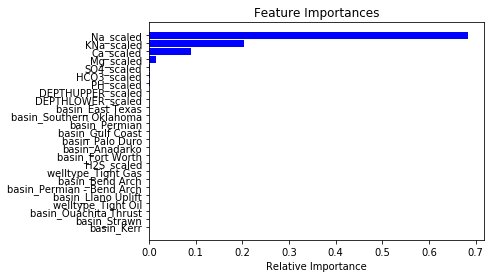

In [65]:
imprf = rf_reg.feature_importances_
indices = np.argsort(imprf)  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), imprf[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Na scaled seems to have the highest effect on predicting TDS values, rightfully so. 

<div class="alert alert-info" role="alert">
    
### Rough Work: Testing out the Different Models for the Unscaled Dataset

</div>

In [ ]:
#Running the values through a RF regressor without scaling
#Random Forest Regression

#Check if the test df is the same column length as the train df
if len(X_train_no_depths.columns) != len(X_test_no_depths.columns):
    #add the missing columns in the test df
    for column_name in X_train_no_depths:
        if not column_name in X_test_no_depths:
            print(column_name)
            X_test_no_depths[column_name] = 0
    
X_test_no_depths = X_test_no_depths.reindex(X_train_no_depths.columns, axis=1)
X_test_no_depths.head()

In [ ]:
# Random forest regression on unscaled data
rf_reg_unscaled = RandomForestRegressor(max_depth=25, n_estimators=100)
rf_reg_unscaled.fit(X_train_no_depths, y_train.ravel())
y_pred_rf_unscaled = rf_reg_unscaled.predict(X_test_no_depths)
rf_unscaled_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_unscaled))
print('The Random Forest regression R^2 value for the unscaled train data (at depth = 20) is {}'.format(rf_reg_unscaled.score(X_train_no_depths, y_train)))
print('The Random Forest regression R^2 value for the unscaled test data (at depth = 20) is {}'.format(rf_reg_unscaled.score(X_test_no_depths, y_test)))
print('The Random Forest RMSE is {}'.format(rf_unscaled_rmse))

In [ ]:
#Gradient Boosting
gb_reg_unscaled = GradientBoostingRegressor(max_depth=20, n_estimators=50, learning_rate=1)
gb_reg_unscaled.fit(X_train_no_depths, y_train.ravel())
y_pred_gb_unscaled = gb_reg_unscaled.predict(X_test_no_depths)
gb_rmse_unscaled = np.sqrt(mean_squared_error(y_test, y_pred_gb_unscaled))
print('The GBRT regression R^2 value for the unscaled train data (at depth = 20 and estimators = 50) is {}'.format(gb_reg_unscaled.score(X_train_no_depths, y_train)))
print('The GBRT regression R^2 value for the unscaled test data (at depth = 20 and estimators = 50) is {}'.format(gb_reg_unscaled.score(X_test_no_depths, y_test)))
print('The GBRT RMSE is {}'.format(gb_rmse_unscaled))

In [ ]:
#k-NN Rregression

kNN_reg_unscaled = KNeighborsRegressor(n_neighbors=5)
kNN_reg_unscaled.fit(X_train_no_depths, y_train.ravel())
y_pred_kNN_unscaled = kNN_reg_unscaled.predict(X_test_no_depths)
kNN_rmse_unscaled = np.sqrt(mean_squared_error(y_test, y_pred_kNN_unscaled))
print('The kNN regression R^2 value for the unscaled train data (at neighbors = 5) is {}'.format(kNN_reg_unscaled.score(X_train_no_depths, y_train)))
print('The kNN regression R^2 value for the unscaled test data (at neighbors = 5) is {}'.format(kNN_reg_unscaled.score(X_test_no_depths, y_test)))
print('The kNN RMSE is {}'.format(kNN_rmse_unscaled))

>The unscaled data can be modeled well with random forests and gradient boosting methods. Let's run cross-validation on them

In [ ]:
#Creating a cross-validation and grid search method on the RF regression
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[20,30], 'n_estimators':[10,50,100,150]}
rf_best = RandomForestRegressor()
rf_gridsearch = GridSearchCV(rf_best, parameters, cv=5)
rf_gridsearch.fit(X_train_no_depths, y_train.ravel())

In [ ]:
rf_gridsearch.best_estimator_
#The best depth is 30 and the optimal n_estimators is 150

In [ ]:
rf_gridsearch.cv_results_

In [ ]:
y_pred_rf_best_estimates = rf_gridsearch.predict(X_test_no_depths)
rf_best_estimates_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_best_estimates))
print('The Random Forest regression R^2 value for the best estimates train data (at depth = 30) is {}'.format(rf_reg_best_estimates.score(X_train_no_depths, y_train)))
print('The Random Forest regression R^2 value for the best estimates test data (at depth = 30) is {}'.format(rf_reg_best_estimates.score(X_test_no_depths, y_test)))
print('The Random Forest RMSE is {}'.format(rf_best_estimates_rmse))

>Based on this data, let's fit the missing depths data using this model.

In [ ]:
X_missing.head()

In [ ]:
#Creating dummies for the two categories in missing set
basin_dummy_missing = pd.get_dummies(X_missing['BASIN'], drop_first=True, prefix='basin')
welltype_dummy_missing = pd.get_dummies(X_missing['WELLTYPE'], drop_first=True, prefix='welltype')

In [ ]:
#RUN ONLY ONCE!!
X_missing = X_missing.join(basin_dummy_missing).join(welltype_dummy_missing).drop(['BASIN','WELLTYPE'], axis=1)

In [ ]:
X_missing.head()

In [ ]:
X_train_no_depths.columns

In [ ]:
#Check if the missing df is the same column length as the train df
if len(X_missing.columns) != len(X_train_no_depths.columns):
    #add the missing columns in the test df
    for column_name in X_train_no_depths:
        if not column_name in X_missing:
            print(column_name)
            X_missing[column_name] = 0

In [ ]:
X_missing = X_missing.reindex(X_train_no_depths.columns, axis=1)
X_missing.head()

In [ ]:
#Predicting the y_missing values for depths according to the best model
y_missing_pred = rf_gridsearch.predict(X_missing)
idx_missing = y_missing.index

In [ ]:
y_missing_pred

In [ ]:
idx_missing

In [ ]:
y_filled = pd.DataFrame(y_missing_pred, columns=['DEPTHUPPER'], index=idx_missing)
y_filled.head()

In [ ]:
#Filling these values back into the main df_prep
df_prep_copy = df_prep.copy()

In [ ]:
df_prep.DEPTHUPPER = df_prep_copy.DEPTHUPPER.fillna(y_filled.DEPTHUPPER)

In [ ]:
df_prep.head(20)

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(df_prep.TDSUSGS, df_prep.DEPTHUPPER, hue=df_prep.BASIN, alpha=0.5, markers='x')

In [ ]:
df_prep.BASIN.unique()

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.palettes import Category20

output_notebook()

p = figure(plot_width=1000, plot_height=800)
p.title.text = 'Click on legend entries to hide the corresponding markers'

for name, color in zip(df_prep.BASIN.unique(), Category20[14]):
    temp_df = df_prep[df_prep.BASIN == name]
    p.scatter(temp_df.TDSUSGS, (temp_df.DEPTHUPPER)*-1, color=color, alpha=0.8, muted_color = color, muted_alpha=0.2, legend=name)
    
#p.scatter('TDSUSGS', 'DEPTHUPPER', source=df_prep, legend='BASIN', color=factor_cmap('BASIN','Category10_3',df_prep.BASIN.unique()))
p.xaxis.axis_label = 'TDSUSGS'
p.yaxis.axis_label = 'DEPTHUPPER'

p.legend.location = "top_right"
p.legend.click_policy="hide"

#output_file('DepthsVSTDS.html')
show(p)